In [162]:
import lightgbm as lgb
from matplotlib import pyplot
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as mpl
from sklearn.model_selection import train_test_split
import shap
from xgboost import XGBRegressor
from xgboost import plot_importance

In [69]:
shap.initjs()


In [2]:
pd.__version__

'1.3.5'

In [3]:
data = pd.read_csv('../data/corona.csv')
display(data.head())

C:\Users\Ehsan\.conda\envs\covid\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (2,3,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
for column in list(data.columns):
    print(column)

CountryName
CountryCode
RegionName
RegionCode
Jurisdiction
Date
C1_School closing
C1_Flag
C2_Workplace closing
C2_Flag
C3_Cancel public events
C3_Flag
C4_Restrictions on gatherings
C4_Flag
C5_Close public transport
C5_Flag
C6_Stay at home requirements
C6_Flag
C7_Restrictions on internal movement
C7_Flag
C8_International travel controls
E1_Income support
E1_Flag
E2_Debt/contract relief
E3_Fiscal measures
E4_International support
H1_Public information campaigns
H1_Flag
H2_Testing policy
H3_Contact tracing
H4_Emergency investment in healthcare
H5_Investment in vaccines
H6_Facial Coverings
H6_Flag
H7_Vaccination policy
H7_Flag
H8_Protection of elderly people
H8_Flag
M1_Wildcard
V1_Vaccine Prioritisation (summary)
V2A_Vaccine Availability (summary)
V2B_Vaccine age eligibility/availability age floor (general population summary)
V2C_Vaccine age eligibility/availability age floor (at risk summary)
V2D_Medically/ clinically vulnerable (Non-elderly)
V2E_Education
V2F_Frontline workers  (non heal

## Notes

If long streak of NaN in between values, drop

In [5]:
BUCKETS = [(0,6), (7, 13), (14, 20), (21, 27)]
RESTRICTION_COLUMNS = [
    "C1_School closing",
    "C2_Workplace closing",
    "C3_Cancel public events",
    "C4_Restrictions on gatherings",
    "C5_Close public transport",
    "C6_Stay at home requirements",
    "C7_Restrictions on internal movement",
    "C8_International travel controls",
    "E1_Income support",
    "E2_Debt/contract relief",
    "E3_Fiscal measures",
    "E4_International support",
    "H1_Public information campaigns",
    "H2_Testing policy",
    "H3_Contact tracing",
    "H4_Emergency investment in healthcare",
    "H5_Investment in vaccines",
    "H6_Facial Coverings",
    "H7_Vaccination policy",
    "H8_Protection of elderly people",
]
FLAG_COLUMNS = [
    "C1_Flag",
    "C2_Flag",
    "C3_Flag",
    "C4_Flag",
    "C5_Flag",
    "C6_Flag",
    "C7_Flag",
    "E1_Flag",
    "H1_Flag",
    "H6_Flag",
    "H7_Flag",
    "H8_Flag",
]
INPUT_COLUMNS = RESTRICTION_COLUMNS + FLAG_COLUMNS
COLUMNS = ["CountryRegion"] + INPUT_COLUMNS + ["ConfirmedCases"]
N_INPUT_DAYS = 7
N_PREDICTION_DAYS = 90
N_DATE_FEATURES_DAYS = N_INPUT_DAYS + N_PREDICTION_DAYS

def set_buckets(num_buckets, prediction_days=N_PREDICTION_DAYS):
    assert not prediction_days%num_buckets, "# of buckets does not divide # of prediction days"
    N_PREDICTION_DAYS = prediction_days
    bucket_size = N_PREDICTION_DAYS//num_buckets
    global BUCKETS
    BUCKETS = [(lo*bucket_size, bucket_size*(lo+1)-1) for lo in range(num_buckets)]
    
set_buckets(num_buckets=9)

def get_country_region(data):
    data["CountryRegion"] =  data["CountryName"] + data["RegionName"].fillna("")
    return data

def get_cases_column_names():
    return ["ConfirmedCases{}DaysAgo".format(N_INPUT_DAYS - 1 - i)
            for i in range(N_INPUT_DAYS - 1)
            ]

def random_from_tuple(t):
    return random.randint(t[0], t[1])

def pct_change(x): # maybe use log change? 
    return (x.iloc[-1] - x.iloc[0]) / x.iloc[0]

def get_rolling_values(df, column, window):
    return np.lib.stride_tricks.as_strided(df[column],
                                           (len(df) - (window - 1), window),
                                           (df[column].values.strides * 2))

def add_cases_columns(inputdf, window=N_INPUT_DAYS):
    arrays = get_rolling_values(inputdf, "ConfirmedCases", window)
    inputdf.reset_index(inplace=True, drop=True)
    inputdf.loc[window - 1:, get_cases_column_names() + ["ConfirmedCases"]] = arrays
    return inputdf

def cases_columns_to_percentages(inputdf):
    cases_columns = get_cases_column_names() + ["Prediction"]
    for cases_column in cases_columns:
        inputdf.loc[:, cases_column] = inputdf.loc[:, cases_column] / inputdf.loc[:, "ConfirmedCases"]
        inputdf.loc[:, cases_column] = inputdf.loc[:, cases_column].shift(1)
    return inputdf

def _add_prediction_rows(inputdf, window=N_PREDICTION_DAYS):
    arrays = get_rolling_values(inputdf, "ConfirmedCases", window)
    inputdf.reset_index(inplace=True, drop=True)
    inputdf.loc[window - 1:, "Prediction"] = pd.Series(list(arrays))
    inputdf = inputdf.explode("Prediction").iloc[N_PREDICTION_DAYS:]
    inputdf.loc[:, "Prediction"] = inputdf \
        .groupby('CountryRegion')['Prediction'] \
        .transform(lambda x: x.shift(-1))
    inputdf.reset_index(inplace=True)
    inputdf.loc[:, "PredictionWindow"] = inputdf.index + 2 - (inputdf["index"] + 1 - N_PREDICTION_DAYS) * N_PREDICTION_DAYS
    inputdf = cases_columns_to_percentages(inputdf)
    return inputdf.drop(columns=["index", "ConfirmedCases"])

def add_prediction_rows(inputdf, window=N_PREDICTION_DAYS):
    arrays = get_rolling_values(inputdf, "ConfirmedCases", window)
    inputdf.reset_index(inplace=True, drop=True)
    inputdf.loc[window - 1:, "Prediction"] = pd.Series(list(arrays))
    inputdf.loc[:, "Prediction"] = inputdf \
        .groupby('CountryRegion')['Prediction'] \
        .transform(lambda x: x.shift(-1))
    inputdf = cases_columns_to_percentages(inputdf)
    inputdf.dropna(inplace=True)
    inputdf["Prediction"] = inputdf["Prediction"].apply(lambda x: [[i,n] for i,n in enumerate(x)])
    inputdf["Prediction"] = inputdf["Prediction"].apply(lambda x: 
                                                        [x[i] for i in [random_from_tuple(tup) for tup in BUCKETS]])
    inputdf = inputdf.explode("Prediction").iloc[N_PREDICTION_DAYS:]
    inputdf["PredictionWindow"] = inputdf["Prediction"].apply(lambda x: x[0]+1)
    inputdf["Prediction"] = inputdf["Prediction"].apply(lambda x: x[1])
    return inputdf.drop(columns=["ConfirmedCases"])

def preprocess_week_change_input(data):
    data = get_country_region(data)
    inputdf = data[COLUMNS]
    inputdf.loc[:, "WeekChangeConfirmedCases"] = inputdf['ConfirmedCases'].rolling(window=7).apply(pct_change)
    inputdf.loc[:, "WeekChangeConfirmedCasesIn3Weeks"] = inputdf \
        .groupby('CountryRegion')['WeekChangeConfirmedCases'] \
        .transform(lambda x: x.shift(-21))
    inputdf.loc[:, INPUT_COLUMNS] = inputdf \
        .groupby('CountryRegion')[INPUT_COLUMNS] \
        .transform(lambda x: x.ffill())
    inputdf.loc[:, FLAG_COLUMNS] = inputdf.loc[:, FLAG_COLUMNS].fillna(1)
    inputdf.loc[:, INPUT_COLUMNS] = inputdf[INPUT_COLUMNS].rolling(window=7).mean()
    inputdf = inputdf[inputdf['ConfirmedCases'] > 1000]
    return inputdf.dropna().reset_index(drop=True)

def preprocess_confirmed_cases_input(data):
    data = get_country_region(data)
    inputdf = data[COLUMNS]
    inputdf = inputdf[inputdf['ConfirmedCases'] > 1000]
    inputdf.loc[:, FLAG_COLUMNS] = inputdf.loc[:, FLAG_COLUMNS].fillna(1)
    inputdf.loc[:, INPUT_COLUMNS] = inputdf.groupby('CountryRegion')[INPUT_COLUMNS].transform(lambda x: x.ffill())
    inputdf = add_cases_columns(inputdf)
    inputdf = add_prediction_rows(inputdf)
    return inputdf.dropna().reset_index(drop=True)

In [6]:
BUCKETS

[(0, 9),
 (10, 19),
 (20, 29),
 (30, 39),
 (40, 49),
 (50, 59),
 (60, 69),
 (70, 79),
 (80, 89)]

In [7]:
inputdf = preprocess_week_change_input(data)

C:\Users\Ehsan\.conda\envs\covid\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Ehsan\.conda\envs\covid\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [164]:
confirmed_cases_input = preprocess_confirmed_cases_input(data)
X_data = confirmed_cases_input[INPUT_COLUMNS + get_cases_column_names() + ["PredictionWindow"]]
y_data = confirmed_cases_input["Prediction"]

In [165]:
X_data.columns = [col_name.replace(' ', '_') for col_name in X_data.columns]

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=42, shuffle=False)

In [168]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [169]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device_type': 'gpu',
    'metric': {'l2', 'l1','mape'},
    'num_leaves': 8,
    'learning_rate': 0.002,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.5,
    'bagging_freq': 15,
    'verbose': 1
}

In [25]:
X_train

,C1_School_closing,C2_Workplace_closing,C3_Cancel_public_events,C4_Restrictions_on_gatherings,C5_Close_public_transport,C6_Stay_at_home_requirements,C7_Restrictions_on_internal_movement,C8_International_travel_controls,E1_Income_support,E2_Debt/contract_relief,...,H6_Flag,H7_Flag,H8_Flag,ConfirmedCases6DaysAgo,ConfirmedCases5DaysAgo,ConfirmedCases4DaysAgo,ConfirmedCases3DaysAgo,ConfirmedCases2DaysAgo,ConfirmedCases1DaysAgo,PredictionWindow
0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1
1,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,14
2,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,22
3,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,32
4,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903393,3.0,2.0,2.0,0.0,1.0,2.0,2.0,4.0,0.0,0.0,...,1.0,1.0,1.0,0.231456,0.363416,0.472096,0.587856,0.690541,0.863001,5
903394,3.0,2.0,2.0,0.0,1.0,2.0,2.0,4.0,0.0,0.0,...,1.0,1.0,1.0,0.231456,0.363416,0.472096,0.587856,0.690541,0.863001,18
903395,3.0,2.0,2.0,0.0,1.0,2.0,2.0,4.0,0.0,0.0,...,1.0,1.0,1.0,0.231456,0.363416,0.472096,0.587856,0.690541,0.863001,29
903396,3.0,2.0,2.0,0.0,1.0,2.0,2.0,4.0,0.0,0.0,...,1.0,1.0,1.0,0.231456,0.363416,0.472096,0.587856,0.690541,0.863001,34


In [170]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=200)])

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 903398, number of used features: 39
[LightGBM] [Info] Using GPU Device: Intel(R) HD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (20.68 MB) transferred to GPU in 0.074993 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.725311
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.022214 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.33 MB) transferred to GPU in 0.019519 secs. 1 sparse feature groups
[LightGBM] [Info] Size of h

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.32 MB) transferred to GPU in 0.021331 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.35 MB) transferred to GPU in 0.021247 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.33 MB) transferred to GPU in 0.017026 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.32 MB) transferred to GPU in 0.021608 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.021022 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.35 MB) transferred to GPU in 0.030167 secs. 1 sparse feature groups
[LightGBM] [Info] Size

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.35 MB) transferred to GPU in 0.020686 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.33 MB) transferred to GPU in 0.020899 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.36 MB) transferred to GPU in 0.022153 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.020328 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.35 MB) transferred to GPU in 0.021345 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.36 MB) transferred to GPU in 0.020860 secs. 1 sparse feature groups
[LightGBM] [Info] Size

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.019980 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.33 MB) transferred to GPU in 0.021019 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.33 MB) transferred to GPU in 0.021479 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.32 MB) transferred to GPU in 0.021463 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.013817 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (10.34 MB) transferred to GPU in 0.022379 secs. 1 sparse feature groups
[LightGBM] [Info] Size

In [28]:
data.ConfirmedCases[100:]

100           86.0
101           92.0
102           92.0
103           92.0
104           92.0
            ...   
221827    141601.0
221828    150628.0
221829    155817.0
221830         NaN
221831         NaN
Name: ConfirmedCases, Length: 221732, dtype: float64

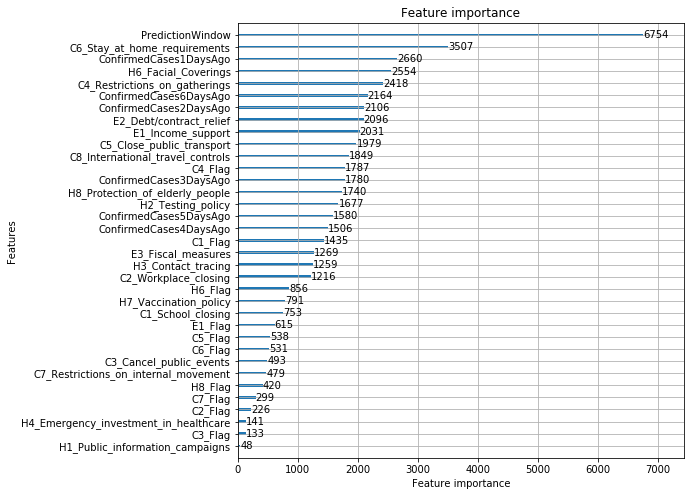

In [146]:
ax = lgb.plot_importance(gbm)
fig = ax.figure
fig.set_size_inches(8, 8)
pyplot.show()

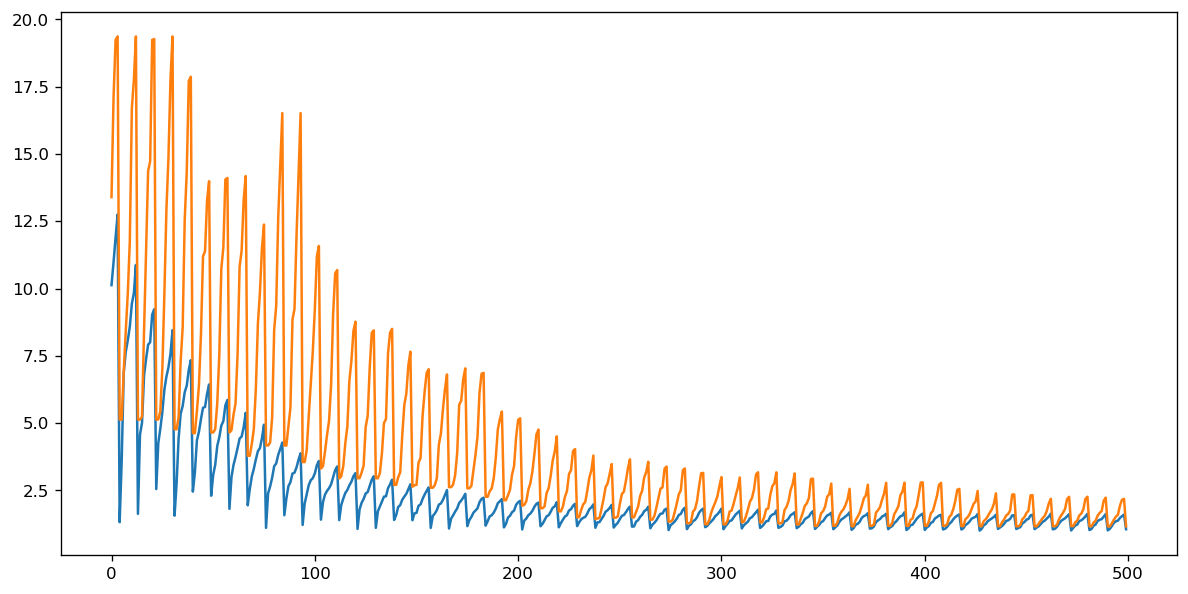

In [172]:
mpl.figure(figsize=(12,6), dpi=120)
mpl.plot(y_test.reset_index(drop=True).values[:500])
mpl.plot(gbm.predict(X_test)[:500])

In [54]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

In [181]:
# save model to file
gbm.save_model('best_lightbm_model.txt')

In [80]:
shap.force_plot(explainer.expected_value, shap_values[1000:2000,:], X_test.iloc[1000:2000,:])

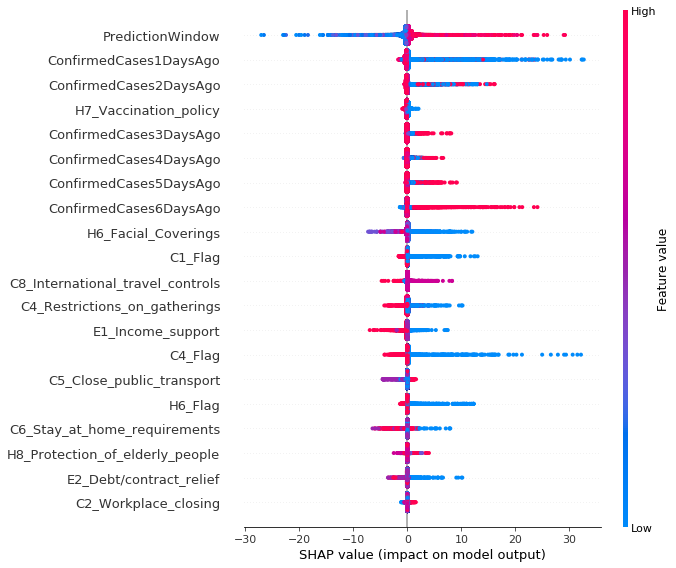

In [61]:
shap.summary_plot(shap_values, X_test)

In [77]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [177]:
confirmed_cases_model = XGBRegressor()
confirmed_cases_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

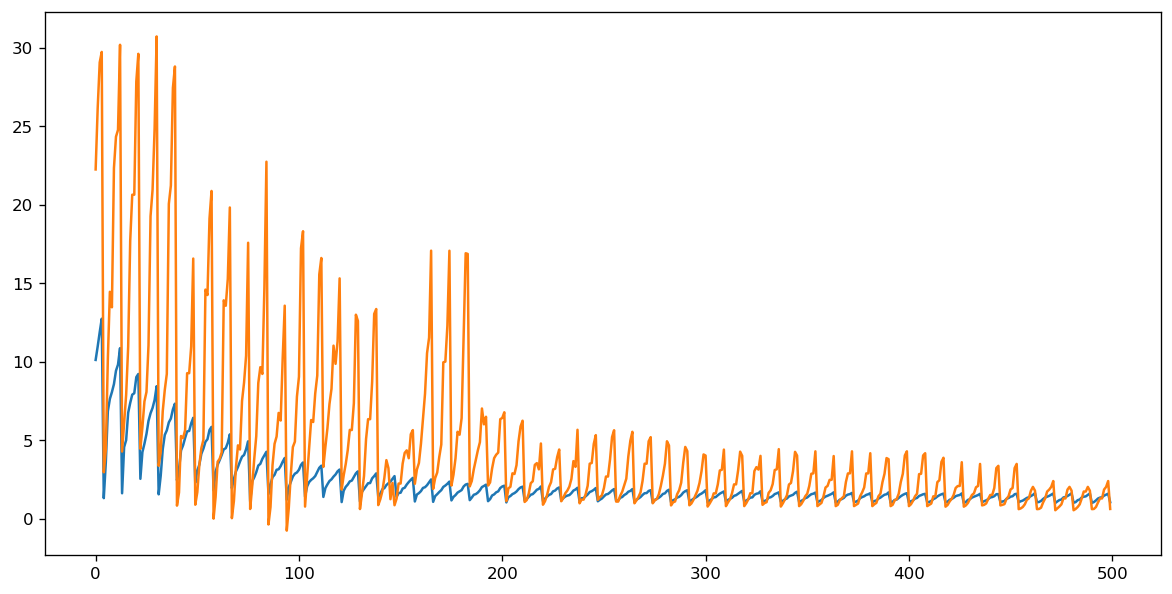

In [179]:
mpl.figure(figsize=(12,6), dpi=120)
mpl.plot(y_test.reset_index(drop=True).values[:500])
mpl.plot(confirmed_cases_model.predict(X_test)[:500])

In [86]:
# with open('confirmed_cases_model.pkl', 'wb') as f:
#     pickle.dump(confirmed_cases_model, f)
with open('confirmed_cases_model.pkl', 'rb') as f:
    loaded = pickle.load(f)
    print(loaded)

In [74]:
(confirmed_cases_input.columns)

Index(['CountryRegion', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H7_Vaccination policy',
       'H8_Protection of elderly people', 'C1_Flag', 'C2_Flag', 'C3_Flag',
       'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag', 'H1_Flag',
       'H6_Flag', 'H7_Flag', 'H8_Flag', 'ConfirmedCases6DaysAgo',
       'ConfirmedCases5DaysAgo', 'ConfirmedCases4DaysAgo',
       'ConfirmedCases3DaysAgo', 'ConfirmedCases2DaysAgo',
       'ConfirmedCases1DaysAgo', 'Prediction'

In [174]:
confirmed_cases_input.PredictionWindow[0]

[0, 1.026300578034682]

In [21]:
confirmed_cases_input = preprocess_confirmed_cases_input(data)
display(confirmed_cases_input.head(10))

,CountryRegion,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,...,H7_Flag,H8_Flag,ConfirmedCases6DaysAgo,ConfirmedCases5DaysAgo,ConfirmedCases4DaysAgo,ConfirmedCases3DaysAgo,ConfirmedCases2DaysAgo,ConfirmedCases1DaysAgo,Prediction,PredictionWindow
0,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.011431,4
1,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.051228,16
2,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.091236,28
3,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.151990,39
4,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.230102,46
5,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.389077,60
6,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.419983,63
7,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.529001,78
8,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986876,0.988146,0.989839,0.991744,0.993438,0.994496,1.574513,86
9,Aruba,1.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.986684,0.988375,0.990277,0.991968,0.993025,0.998520,1.029803,9
